# Installing all the dependencies and libraries

In [13]:
!pip install tensorflow opencv-python matplotlib imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25854 sha256=14436d03e64f70bd7b700ca1d878c4e9b63268e69201e0f32a5d4ae9f51cca23
  Stored in directory: c:\users\csach\appdata\local\pip\cache\wheels\c2\02\32\f3617a9f68bcc67eda3ebeb4514eba18f62e81ff439428109d
Successfully built imutils


# Importing the necessary libraries and functions.

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
import pandas as pd
import glob
from imutils import paths
from skimage.filters import sobel
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from skimage.filters import roberts, scharr, prewitt
from scipy import ndimage as nd
import seaborn as sb
import pickle

# Deciding the important and necessary features. (PLAN)

<h3>1) Original Image (4 Features - RED, BLUE, GREEN and GRAY Pixels).</h3>
The original image itself is a very important feature conveying about the intenity levels and basic colours, etc.
<br>

<h3>2) Edge filter's data (4 Features - SOBEL and CANNY Filters).</h3>
Canny Edge detector filter, Sobel Edge detection filter, Roberts edge detection filter.
This shall be really a helpful feature as the edges are the most important features highlighting the background and the main oject.
<br>

<h3>3) Texture filter's data (12 Features - GABOR FILTERS with changing parameters).</h3>
Gabor filters (different orientations), Gray level co-occurence matrix, etc.
<br>

<h3>4) Standard features like (std.deviation, variance, mean)</h3>
These are the standard features that can be extracted from imaage data set and thus can act as a good features.

<br>

<h2>The total number of features-columns in the pandas dataframe will be, >10.</h2>
<hr>

# Deciding on the model going to be used. (PLAN)

<h3>We will use the Random Forest Classifier for building the image classifier. </h3>


<hr>

##  The Ground Truth Values for the 4 insect classes will be:
<h3>1) 0 - Transverse LadyBug</h3>
<h3>2) 1 - 7 Spotted LadyBug</h3>
<h3>3) 2 - 22 Spotted LadyBug</h3>



# Defining and populating the important lists and constants

In [23]:
SMAX = 128

image_set = [] # Will have all the images for us.
image_set_labels = [] # Will have all the labels for us.
image_set_predict = []
image_set_labels_predict = []
imagePaths = list(paths.list_images(r"C:\Users\csach\OneDrive\Desktop\7 train"))

for imag in imagePaths:
    img = cv2.imread(imag)
    img = cv2.resize(img,(SMAX,SMAX))
    #print(img.shape)
    image_set.append(img)
    image_set_labels.append(str(imag).split('\\')[6].split(' ')[0])
    
    
imagePaths_predict = list(paths.list_images(r"C:\Users\csach\OneDrive\Desktop\7 validate"))

for imag in imagePaths_predict:
    img = cv2.imread(imag)
    img = cv2.resize(img,(SMAX,SMAX))
    #print(img.shape)
    image_set_predict.append(img)
    image_set_labels_predict.append(str(imag).split('\\')[6].split(' ')[0])


In [24]:
image_set = np.array(image_set)
image_set_labels = np.array(image_set_labels)
image_set_predict = np.array(image_set_predict)
image_set_labels_predict = np.array(image_set_labels_predict)
print(image_set.shape)
print(image_set_labels.shape)
print(image_set_predict.shape)
print(image_set_labels_predict.shape)

(480, 128, 128, 3)
(480,)
(80, 128, 128, 3)
(80,)


# Changing the data as per our convinience. (Labels,etc)

In [25]:
train_labels = []
predict_labels = []
for i in image_set_labels:
    if i =='transverse':
        train_labels.append(0)
    elif i=='7spotted':
        train_labels.append(1)
    elif i=='22spotted':
        train_labels.append(2)
    elif i=='polished':
        train_labels.append(3)
        
Xtrain_labels = np.array(train_labels)

for i in image_set_labels_predict:
    if i =='transverse':
        predict_labels.append(0)
    elif i=='7spotted':
        predict_labels.append(1)
    elif i=='22spotted':
        predict_labels.append(2)
    elif i=='polished':
        predict_labels.append(3)

Xpredict_labels = np.array(predict_labels)
    

# Defining a function to extract features and making a FrameWork.

In [26]:
def feature_select(image_set):
    dataset = pd.DataFrame()
    for img in image_set:
        temp_def = pd.DataFrame()
        
       
        ## Extracting the ccolor channels as features.
        img_BGR = img
        
        (img_BLUE,img_GREEN,img_RED) = cv2.split(img_BGR)
        img_BLUE = img_BLUE/255.0
        img_RED = img_RED/255.0
        img_GREEN = img_GREEN/255.0
        temp_def["Blue Val"]=img_BLUE.reshape(-1) # FEATURE 1
        temp_def["Green Val"]=img_GREEN.reshape(-1) # FEATURE 2
        temp_def["Red Val"]=img_RED.reshape(-1) # FEATURE 3
    
        ## GRAY IMAGE as feature.
        img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
        img_gray = img_gray/255.0
        img_gray = img_gray.reshape(-1) # FEATURE 4
        temp_def["Gray Val"] = img_gray 
    
        
        ## VERTICAL and HORIZONTAL SOBEL FILTERS.
        img_g = img
        img_gg = cv2.cvtColor(img_g,cv2.COLOR_RGB2GRAY)
        edge_sobel_v = cv2.Sobel(img_gg,cv2.CV_64F,0,1,ksize=5) # FEATURE 5
        temp_def["Vetical Sobel Edge"] = edge_sobel_v.reshape(-1)
        
        edge_sobel_h = cv2.Sobel(img_gg,cv2.CV_64F,1,0,ksize=5) # FEATURE 6
        temp_def["Horizontal Sobel Edge"] = edge_sobel_h.reshape(-1)
        
        ## CANNY EDGE FILTERS.
        img_canny1 = cv2.Canny(img_g,100,600)
        temp_def["Canny Edge 1"]=img_canny1.reshape(-1)

        img_canny2 = cv2.Canny(img_g,255/3,255)
        temp_def["Canny Edge 2"]=img_canny2.reshape(-1)
        
        ## ROBERTS EDGE FILTERS. 
        img_roberts = roberts(img_gg)
        temp_def["Roberts Edge"] = img_roberts.reshape(-1)

        ## SCHARR EDGE FILTERS. 
        img_scharr = scharr(img_gg)
        temp_def["Scharr Edge"] = img_scharr.reshape(-1)
        
        ## PREWITT EDGE FILTERS. 
        img_prewitt = scharr(img_gg)
        temp_def["Prewitt Edge"] = img_prewitt.reshape(-1)
        
        ## MEDIAN
        #med_img = nd.median_filter(img_gg,size=7)
        #med_img = med_img.reshape(-1)
        #temp_def['Median'] = med_img
        
        ## VARIANCE
        #var_img = nd.generic_filter(img_gg,np.var,size=3)
        #temp_def['Variance'] = var_img.reshape(-1);
        
        ## GABOR FILTERS (SET OF FILTERS)
       # imgp = img_gg
       # kernel_size = 9
       # num = 1;
       # for sigma in range(1,4): # Keeping the sigmas low so as to not miss on the features.
       #     for theta_mult in range(0,4):
       #         theta = (theta_mult/2)*np.pi
       #         wavelen = 1*np.pi/4
       #         gamma = 0.1
       #         phi = 0.8
       #         label = "Gabor Texture {}".format(num)
       #         kernel = cv2.getGaborKernel((kernel_size,kernel_size),sigma,theta,wavelen,gamma,phi,ktype=cv2.CV_32F)
       #         filtered_img = cv2.filter2D(imgp,cv2.CV_8UC3,kernel)
       #         temp_def[label] = filtered_img.reshape(-1)
       #         num = num+1
        
        
        
        dataset = pd.concat([dataset,temp_def],axis=0)
    
    return dataset

    

# Getting features for the Training set. (Training is done on this set)
<br>
<h3> A total of 23 features were extracted from each image and which was later converted to the necessary vector form. </h3>
<h3> These were: </h3>
<h3> Red Channel Pixels </h3>
<h3> Blue Channel Pixels </h3>
<h3> Green Channel Pixels </h3>
<h3> Gray Channel Pixels </h3>
<h3> Vertical Sobel Edge filter response </h3>
<h3> Horizontal Sobel Edge filter response </h3>
<h3> Canny Edge filter response (High threshold values)</h3>
<h3> Canny Edge filter response (Lower threshold values) </h3>
<h3> Roberts Edge filter response</h3>
<h3> Scharr Edge filter response </h3>
<h3> Prewitt Edge filter response </h3>
<h3> Multiple Gabor filter responses where each was different in sigma/angular orientation. </h3>

In [27]:
dataset_train = feature_select(image_set)
dataset_train

,Blue Val,Green Val,Red Val,Gray Val,Vetical Sobel Edge,Horizontal Sobel Edge,Canny Edge 1,Canny Edge 2,Roberts Edge,Scharr Edge,Prewitt Edge
0,0.149020,0.384314,0.266667,0.321569,0.0,0.0,0,0,0.056148,0.044335,0.044335
1,0.180392,0.415686,0.298039,0.352941,0.0,284.0,0,0,0.038523,0.042903,0.042903
2,0.196078,0.431373,0.313725,0.368627,0.0,166.0,0,0,0.027730,0.026693,0.026693
3,0.200000,0.447059,0.309804,0.376471,0.0,-58.0,0,0,0.019996,0.016995,0.016995
4,0.203922,0.443137,0.301961,0.372549,0.0,174.0,0,0,0.018602,0.014031,0.014031
...,...,...,...,...,...,...,...,...,...,...,...
16379,0.058824,0.360784,0.211765,0.282353,0.0,-124.0,0,0,0.000000,0.008319,0.008319
16380,0.043137,0.368627,0.219608,0.286275,0.0,76.0,0,0,0.007843,0.005546,0.005546
16381,0.031373,0.384314,0.239216,0.301961,0.0,208.0,0,0,0.007843,0.010585,0.010585
16382,0.019608,0.400000,0.250980,0.313725,0.0,192.0,0,0,0.015686,0.015843,0.015843


# Getting features for the Validation set. (Classification tests on this set)
<br>
<h3> A total of 23 features were extracted from each image and which was later converted to the necessary vector form. </h3>

In [28]:
dataset_predict = feature_select(image_set_predict)
dataset_predict

,Blue Val,Green Val,Red Val,Gray Val,Vetical Sobel Edge,Horizontal Sobel Edge,Canny Edge 1,Canny Edge 2,Roberts Edge,Scharr Edge,Prewitt Edge
0,0.090196,0.149020,0.262745,0.176471,0.0,0.0,0,0,0.101734,0.083709,0.083709
1,0.145098,0.223529,0.337255,0.247059,0.0,-486.0,0,0,0.051131,0.051492,0.051492
2,0.141176,0.243137,0.368627,0.270588,0.0,-734.0,0,0,0.034300,0.038220,0.038220
3,0.074510,0.196078,0.329412,0.223529,0.0,14.0,0,0,0.046151,0.052564,0.052564
4,0.027451,0.145098,0.294118,0.176471,0.0,1130.0,0,0,0.117973,0.081345,0.081345
...,...,...,...,...,...,...,...,...,...,...,...
16379,0.650980,0.698039,0.639216,0.674510,0.0,684.0,0,0,0.019608,0.024418,0.024418
16380,0.682353,0.713725,0.670588,0.698039,0.0,-80.0,0,0,0.019608,0.003676,0.003676
16381,0.666667,0.690196,0.658824,0.678431,0.0,-738.0,0,255,0.043137,0.043856,0.043856
16382,0.631373,0.631373,0.662745,0.639216,0.0,-678.0,0,0,0.007843,0.029852,0.029852


In [29]:
num_of_features = dataset_train.shape[1]
image_features_train = np.expand_dims(dataset_train,axis=0)
Xtrain = np.reshape(image_features_train, (480,-1))
Xtrain.shape

(480, 180224)

In [30]:
image_features_predict = np.expand_dims(dataset_predict,axis=0)
Xpredict = np.reshape(image_features_predict,(80,-1))
Xpredict.shape

(80, 180224)

# Training the model after selecting the best fit estimators/no of trees using the training set.
<h3> Here multiple training iterations was done to select the best number of trees/estimators and it was around 400.</h3>

In [31]:
RANDOM_FOREST_MODEL = RandomForestClassifier(n_estimators = 1000, random_state = 42)

RANDOM_FOREST_MODEL.fit(Xtrain,Xtrain_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

# Visualising the data using the array of classification results.

In [32]:
test_results_on_predictset = RANDOM_FOREST_MODEL.predict(Xpredict)
test_results_on_predictset

array([2, 0, 2, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 3, 3, 2, 0, 2, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 0, 0, 2, 0,
       0, 0, 3, 0, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0])

# Running the Validation set on the model for testing.

In [33]:
print("Accuracy of the model is = ", metrics.accuracy_score(Xpredict_labels,test_results_on_predictset))

Accuracy of the model is =  0.8125


In [34]:
img_test = cv2.imread(r"C:\Users\csach\OneDrive\Desktop\transverse imggsss.jpg")
img_test = cv2.resize(img_test,(128,128))
lst = img_test
feat = feature_select(np.array([lst]))
feat = np.expand_dims(feat,axis = 0)
featfeat = np.reshape(feat,(1,-1))
prediction = RANDOM_FOREST_MODEL.predict(featfeat)
prediction

array([0])

# Visualising the prediction data using a Confusion Matrix

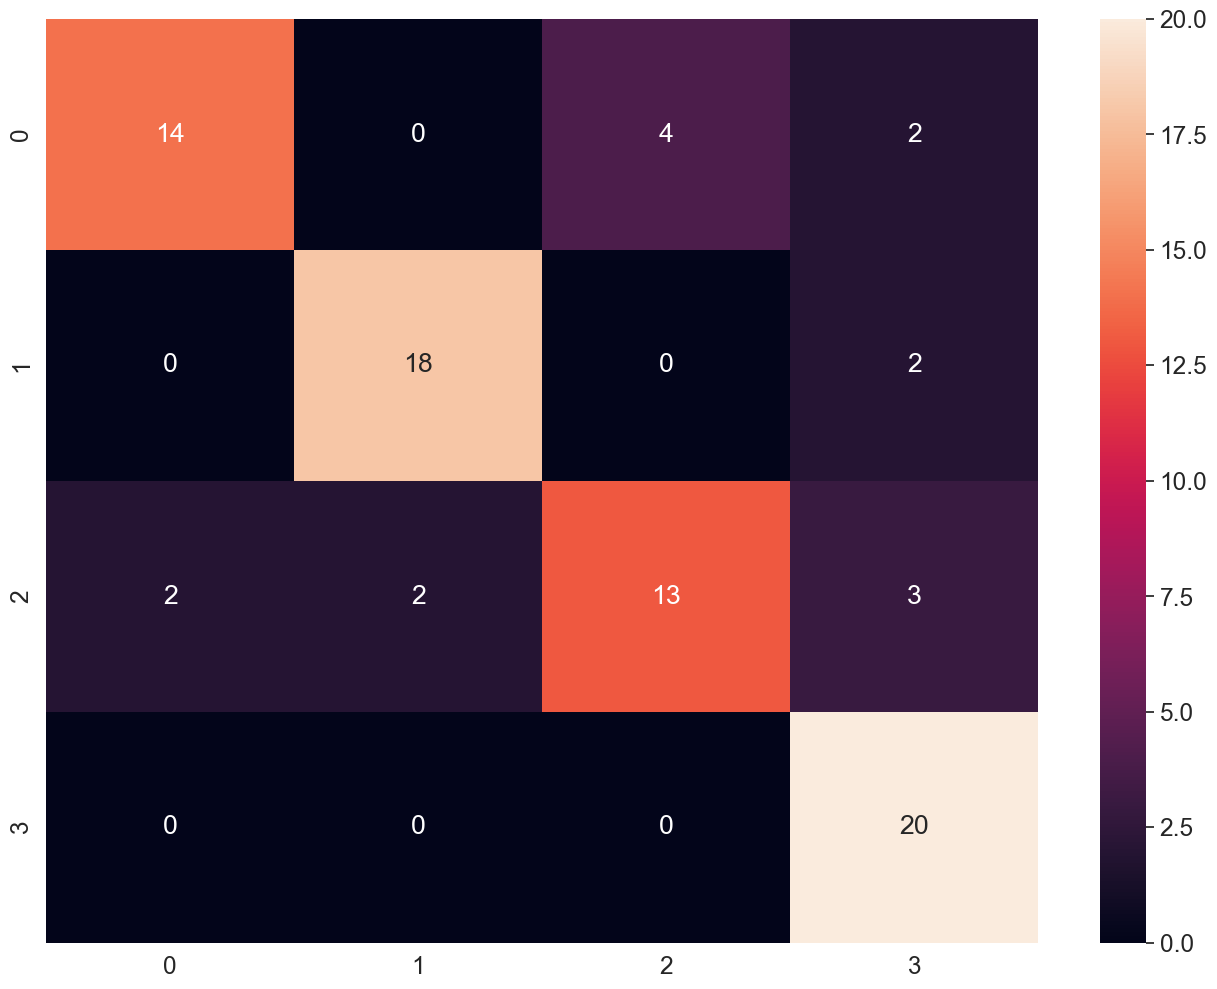

In [35]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Xpredict_labels,test_results_on_predictset)

fig1,ax1 = plt.subplots()
fig1.set_figwidth(16)
fig1.set_figheight(12)
sb.set(font_scale=1.6)
sb.heatmap(conf_matrix,annot=True)
plt.show()

# Calculating and printing the necessary classification report.

In [36]:
from sklearn.metrics import classification_report
acc_report = classification_report(Xpredict_labels,test_results_on_predictset)
acc_report_data = pd.DataFrame(classification_report(Xpredict_labels,test_results_on_predictset,output_dict=True))
acc_report_data.to_csv("Image Classification Acc report")
acc_report_data

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.875000,0.9,0.764706,0.740741,0.8125,0.820112,0.820112
recall,0.700000,0.9,0.650000,1.000000,0.8125,0.812500,0.812500
f1-score,0.777778,0.9,0.702703,0.851064,0.8125,0.807886,0.807886
support,20.000000,20.0,20.000000,20.000000,0.8125,80.000000,80.000000


# Saving the trained Model using the pickle library for further uses.

In [37]:
file_name = "RandomForestClassifier for LadyBugs"
pickle.dump(RANDOM_FOREST_MODEL,open(file_name,"wb"))